In [1]:
import os,sys
def add_path_to_local_module(module_name):
    module_path = os.path.abspath(os.path.join(module_name))
    if module_path not in sys.path:
        sys.path.append(module_path)
add_path_to_local_module("epitran")
add_path_to_local_module("panphon")

import panphon.featuretable
ft = panphon.featuretable.FeatureTable()
a_long,a_short = ft.word_fts('aː ă')
print(a_long)
print(a_short)
print(a_long.weighted_distance(a_short))

<Segment [+syl, +son, -cons, +cont, -delrel, -lat, -nas, 0strid, +voi, -sg, -cg, 0ant, -cor, 0distr, -lab, -hi, +lo, +back, -round, -velaric, +tense, +long]>
<Segment [+syl, +son, -cons, +cont, -delrel, -lat, -nas, 0strid, +voi, -sg, -cg, 0ant, -cor, 0distr, -lab, -hi, +lo, +back, -round, -velaric, +tense, -long]>
0.25


In [2]:
import numpy as np

import os,sys

def add_path_to_local_module(module_name):
    module_path = os.path.abspath(os.path.join(module_name))
    if module_path not in sys.path:
        sys.path.append(module_path)
add_path_to_local_module("epitran")
add_path_to_local_module("panphon")


import panphon
import panphon.distance
import epitran
import pickle

from wordgen import *

In [3]:
wg = WordgenLearned(3,"ind-Latn")

Loading Epitran with language code ind-Latn... success!


In [4]:
# wg.learn_distribution("slice.txt")

In [5]:
# wg.generate_word()

Now we are interested in generating a "phonology" for a fictional language. This constitutes an equivalence relation on the set of IPA symbols. Then generate an orthography to display things. 

In [6]:
ft=panphon.FeatureTable()
dst=panphon.distance.Distance()

/home/ebrahim/wordgen2/panphon/panphon/distance.py:73: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  dogol_prime = yaml.load(f.read())


In [7]:
dst.weighted_feature_edit_distance('k','ɡ'),dst.weighted_feature_edit_distance('k','d')

(0.125, 1.1875)

In [8]:
epi = epitran.Epitran("eng-Latn")

In [9]:
epi.transliterate("party")

'pɑɹti'

In [10]:
ft = panphon.featuretable.FeatureTable()

In [11]:
ft.word_array(['voi'],"pɑɹti")

array([[-1],
       [ 1],
       [ 1],
       [-1],
       [ 1]])

In [12]:
for v in ft.word_to_vector_list("pɑɹti",numeric=True): print(list(v))

[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, 1, -1, 0, 1, -1, -1, -1, -1, -1, 0, -1]
[1, 1, -1, 1, 0, -1, -1, 0, 1, -1, -1, 0, -1, 0, -1, -1, 1, 1, -1, -1, 1, -1]
[-1, 1, -1, 1, -1, -1, -1, 0, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 0, -1]
[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 0, -1]
[1, 1, -1, 1, -1, -1, -1, 0, 1, -1, -1, 0, -1, 0, -1, 1, -1, -1, -1, -1, 1, -1]


In [13]:
# I think these weights are chosen by panphon authors based on their sense for what matters when it comes
# to phonological differences. (Probably based on some empirical knowledge since they are linguists...)
print(list(zip(dst.fm.names,dst.fm.weights)))

[('syl', 1.0), ('son', 1.0), ('cons', 1.0), ('cont', 0.5), ('delrel', 0.25), ('lat', 0.25), ('nas', 0.25), ('strid', 0.125), ('voi', 0.125), ('sg', 0.125), ('cg', 0.125), ('ant', 0.25), ('cor', 0.25), ('distr', 0.125), ('lab', 0.25), ('hi', 0.25), ('lo', 0.25), ('back', 0.25), ('round', 0.25), ('velaric', 0.125), ('tense', 0.25), ('long', 0.125)]


To generate a phonology, here's my idea:
- Pick a random batch of weights like the one shown above. Center your choice on the one above, and draw from a gaussian distribution... somehow pick variance intelligently. The chosen weights will be fixed for the phonology generation.
- Pick (randomly? or hard coded from start?) a maximum number of phonemes $M$, like 40 or 50.
- Gather all IPA symbols somehow. There's the csv files in panphon/data like ipa_all.csv... but idk if that will get everything the epitrans.transliterate can produce. Instead, you could  go through your directory of saved WordgenLearned objects and union together all the sets of ipa symbols found in there (excluding the start and end tokens). Let's call the resulting set of IPA symbols $S$.
- The phonology will be a mapping $S\rightarrow\mathbb{N}$. Think of at as an enumeration of equivalence classes. The weights chosen above define a particular distance function $d:S\times S\rightarrow \mathbb{R}$. To generate a phonology:
  - Start with an injective mapping $f:S\rightarrow\mathbb{N}$.
  - Randomly pick an element $x$ of $S$ and randomly choose a radius $r$. The radius will be pulled from a distribution that is fixed beforehand (uniform? gaussian? this will require experimentation to pick).
  - For each $y\in S$ with $d(y,x)<r$, redefine $f(y)$ to be $f(x)$ (i.e. "identify" those two sounds).
  - Now check how many phonemes there are (i.e. size of range of $f$); if it's $\leq$ the maximum $M$, then stop. Otherwise pick another $x\in S$ and repeat the process.

In [14]:
print(wg.load_ipa_chars('eng-Latn'))

{'k', 'ɪ', 'ʊ', 'w', 'd', 'v', 't͡ʃ', 'e', 'f', 'ŋ', 'l', 'u', 'ʔ', 'd͡ʒ', 'p', 'ɡ', 'b', 'ɹ', 'z', 'h', 'n̩', 'ʒ', 'a', 'i', 's', 'm̩', 'ɔ', 'j', 'ʌ', 'θ', 'n', 'ɹ̩', 'm', 'ð', 'æ', 'ʃ', 'ɛ', 'ɾ', 't', 'ɑ', 'o', 'ə'}


In [15]:
print(list(
    zip(
        ft.word_to_vector_list('a',numeric=True)[0],
        dst.fm.names,
)))

[(1, 'syl'), (1, 'son'), (-1, 'cons'), (1, 'cont'), (-1, 'delrel'), (-1, 'lat'), (-1, 'nas'), (0, 'strid'), (1, 'voi'), (-1, 'sg'), (-1, 'cg'), (0, 'ant'), (-1, 'cor'), (0, 'distr'), (-1, 'lab'), (-1, 'hi'), (1, 'lo'), (1, 'back'), (-1, 'round'), (-1, 'velaric'), (1, 'tense'), (-1, 'long')]


In [16]:
ft.word_fts('a')

[<Segment [+syl, +son, -cons, +cont, -delrel, -lat, -nas, 0strid, +voi, -sg, -cg, 0ant, -cor, 0distr, -lab, -hi, +lo, +back, -round, -velaric, +tense, -long]>]

In [17]:
a_long,a_short = ft.word_fts('aː ă')

In [18]:
a_long.weighted_distance(a_short)

0.25

In [19]:
dst.weighted_feature_edit_distance('a','ɔ'),0.25+0.25+0.125

(0.75, 0.625)

In [20]:
a_short

<Segment [+syl, +son, -cons, +cont, -delrel, -lat, -nas, 0strid, +voi, -sg, -cg, 0ant, -cor, 0distr, -lab, -hi, +lo, +back, -round, -velaric, +tense, -long]>

In [21]:
import numpy as np

In [22]:
ft = panphon.featuretable.FeatureTable()
ft.weights

[1.0,
 1.0,
 1.0,
 0.5,
 0.25,
 0.25,
 0.25,
 0.125,
 0.125,
 0.125,
 0.125,
 0.25,
 0.25,
 0.125,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.125,
 0.25,
 0.125]

In [28]:
len(ft.weights)

22

In [24]:
# Choose random weights based around the ones that were chosen for panphon. 
# This amounts to a choice of metric on the space of phones
weights = np.array([np.exp(np.random.normal(np.log(w),0.25)) for w in ft.weights])
weights *= sum(ft.weights)/weights.sum()
print(weights)

[0.93480061 1.0743817  0.54472314 0.37755713 0.24315529 0.28724185
 0.2771729  0.07627738 0.13799381 0.09026015 0.10449353 0.45035036
 0.25430334 0.12561608 0.37187476 0.27879092 0.34488675 0.33441817
 0.2644237  0.14337851 0.27465681 0.13424311]


In [25]:
a_short.weighted_distance(a_long)

0.25

In [26]:
a_short.weighted_distance(a_long,weights)

0.26848621936619627

In [174]:
ipa_chars = wg.load_ipa_chars('eng-Latn')

dists = []
for c1 in ipa_chars:
    for c2 in ipa_chars:
        s1,s2 = ft.word_fts(c1),ft.word_fts(c2)
        assert(len(s1)==1)
        assert(len(s2)==1)
        s1,s2 = s1[0],s2[0]
        if c1 != c2 : dists.append(s1.weighted_distance(s2))
max_dist,min_dist = max(dists),min(dists)
max_dist,min_dist

(10.875, 0.25)

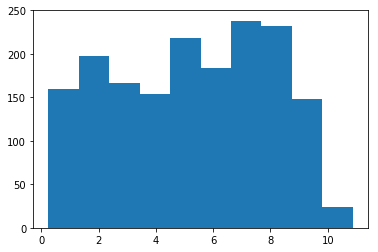

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(dists)
plt.show()

In [193]:
def within_r_of(ipa_char,r,lang_code,weights):
    ipa_chars = wg.load_ipa_chars(lang_code)
    s1 = ft.word_fts(ipa_char)
    assert(len(s1)==1)
    s1 = s1[0]
    ball = []
    for c2 in ipa_chars:
        s2 = ft.word_fts(c2)
        assert(len(s2)==1)
        s2=s2[0]
        if s2.weighted_distance(s1,weights) < r : ball.append(c2)
    return ball

weights = np.array([np.exp(np.random.normal(np.log(w),0.25)) for w in ft.weights])
weights *= sum(ft.weights)/weights.sum()
within_r_of('ɡ',1.5,'eng-Latn',weights)

['k', 'ɡ']

In [ ]:
ipa_chars = wg.load_ipa_chars('eng-Latn')
M = 20
step_size = (max_dist-min_dist)/float((len(ipa_chars)-M)*50)
spread = step_size/2.
for r0 in np.arange(min_dist,max_dist,step_size):
    r = np.random.normal(r0,spread)
    print(within_r_of('ɡ',r,'eng-Latn',weights))

In [217]:
weights = np.array([np.exp(np.random.normal(np.log(w),0.25)) for w in ft.weights])
weights *= sum(ft.weights)/weights.sum()
ipa_chars = list(wg.load_ipa_chars('eng-Latn')) # now this is an ordered list, kind of serving as an enumeration
num_chars = len(ipa_chars)
projection = [n for n in range(num_chars)] # we start with identity mapping and will gradually identify things
# think of projection as mapping from indices representing ipa_chars to equivalence classes
# the number of equivalence classes is len(set(projection))
M = 20
step_size = (max_dist-min_dist)/float((len(ipa_chars)-M)*500)
spread = step_size/2.
for r0 in np.arange(min_dist,max_dist,step_size):
    r = np.random.normal(r0,spread)
    ipa_char_index = np.random.randint(num_chars)
    s0 = ft.word_fts(ipa_chars[ipa_char_index])
    assert(len(s0)==1)
    s0 = s0[0]
    for n in range(num_chars):
        s = ft.word_fts(ipa_chars[n])
        assert(len(s)==1)
        s = s[0]
        if s0.weighted_distance(s,weights)<r:
            projection[n]=projection[ipa_char_index]
    if len(set(projection))<=M: break

In [218]:
for p in set(projection):
    print([ipa_chars[n] for n in range(num_chars) if projection[n]==p])

['k', 'ɡ']
['d', 'z', 'ʒ', 's', 'θ', 'ð', 'ʃ', 't']
['m']
['w']
['ɾ']
['t͡ʃ', 'd͡ʒ']
['v', 'f']
['ɪ', 'ʊ', 'e', 'a', 'i', 'ɔ', 'ʌ', 'æ', 'ɛ', 'ɑ', 'o', 'ə']
['ŋ']
['l']
['u']
['ʔ']
['p', 'b']
['ɹ']
['h']
['n̩']
['m̩']
['j']
['n']
['ɹ̩']
